In [2]:
import json
from bs4 import BeautifulSoup
from pprint import pprint
import pandas as pd
import re


def clean_text(raw_text: str):
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

In [3]:
import tensorflow as tf
import tensorflow_hub as tfhub

# from data_loader import read_json_as_df

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

pd.options.display.max_colwidth = 1000

In [4]:
def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = tfhub.load(module_url)

In [6]:
train_df = read_json_as_df('../Data/combined-train.json')
test_df = read_json_as_df('../Data/combined-test.json')

In [6]:
train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

In [7]:
tf.__version__

'2.1.0'

In [8]:
xtrain, ytrain = model(train_df.text).numpy(), train_df.priority
xtest, ytest = model(test_df.text).numpy(), test_df.priority

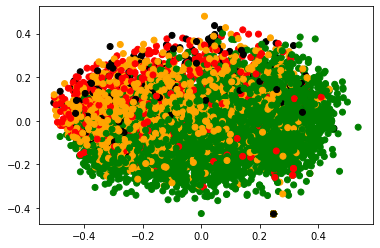

In [9]:
pca = PCA(n_components=2).fit(xtrain)

features_2d = pca.transform(xtrain)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

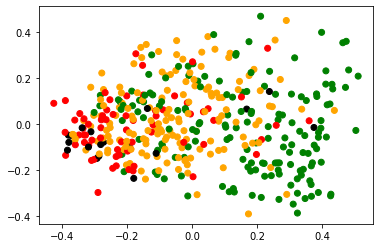

In [10]:
pca = PCA(n_components=2).fit(xtest)

features_2d = pca.transform(xtest)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [11]:
%%time

params = {'C': scipy.stats.expon(scale=10), 
          'gamma': scipy.stats.expon(scale=.1), 
          'kernel': ['rbf'], 
          'class_weight':['balanced'],
          'cache_size': [1024]}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

svc_searched_clf = clf.fit(xtrain, ytrain)

print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Best Params: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.5409955232083764 

SVC(class_weight='balanced', gamma=1.0) 

Wall time: 14min 31s


In [12]:
predicted_priority = svc_searched_clf.predict(xtest)    
print_results(ytest, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.70      0.69      0.70       154
    escalate       0.57      0.47      0.52        17
       green       0.77      0.90      0.83       159
         red       0.60      0.41      0.48        69

    accuracy                           0.72       399
   macro avg       0.66      0.62      0.63       399
weighted avg       0.71      0.72      0.71       399


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.5653186856188381

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.93      0.82      0.87       240
       green       0.77      0.90      0.83       159

    accuracy                           0.85       399
   macro avg       0.85      0.86      0.85       399
weighted avg       0.86      0.85      0.86       399


----URGENT - 'red + escalate